# Social Media analysis of Polaris Idustries

#### In this analysis, I have got the social media posts about Polaris Industries from Twitter. The steps that I have followed in my anaysis are:
    - Search for the data from Twitter with the keywords 'Polaris'
    - Data Cleaning and Transformation
    - Exploratory Analysis and Visualization
    - Sentiment analysis of the tweets to identify positive and negative tweets, and continuing the analysis using negative    tweets as Polaris may need to pay more attention to these tweets and the posters
    - Word to Vector to find contextually similar words for the words in the negative tweets
    - N-grams to find the commonly occurring pairs of words in the tweets with negative sentiment
    - Topic modelling to identify the different topics people are tweeting about to address people's concerns with Polaris

### Load the libraries

In [106]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import json
import string
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
plt.style.use('ggplot')
from wordcloud import WordCloud,STOPWORDS
import sys  
from nltk.corpus import stopwords
stop = stopwords.words('english')
from gensim.models import Word2Vec
import nltk
import gensim
from gensim import corpora
from datetime import datetime
from ggplot import *
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

## Read the csv files which have all the tweets

During my analysis, I accessed the Twitter Official API to extract the tweets relevant to Polaris Industries. The Twitter API fetches tweets about specific keywords only for the previous seven days. The number of tweets about Polaris Industries during the last seven days were few and would not be useful for analysis as text mining usually requires a lot of data. Similarly, the live stream extraction of tweets about Polaris would give only a few tweets for analysis. 
Hence, I made use of a code that was already present on github which mimicked the twitter search and fetched the tweets for time frames longer than 7 days. 
This is the link to the code,
https://github.com/Jefferson-Henrique/GetOldTweets-python

I did some modifications to the code and ran it to fetch tweets using the keyword 'Polaris'. 

This file has the tweets which are searched using the keyword __'Polaris'__

In [ ]:
tweets = pd.read_csv('C:\\Users\\venka\\Documents\\PyCodes\\GetOldTweets/output_got.csv', sep=';',skiprows=[5223])

__Older tweets are loaded successfully. But, the username column is blank. Fortunately, we had username details in the link. Hence using regex to extract the usernames__ 

In [81]:
tweets['username'] = tweets['permalink'].str.extract('https://twitter.com/(.*)/status.*')
tweets.head(5)

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,WaltsOutdoor,2017-06-17 12:23,0,0,2017 Polaris RZR XP1000 w/ ride command http:/...,NaN,NaN,NaN,876112957293441029,https://twitter.com/WaltsOutdoor/status/876112...
1,powerpacinc,2017-06-17 10:40,0,0,2013 Polaris RZR 570 EFI http:// bit.ly/2rBG8tX,NaN,NaN,NaN,876087058720325635,https://twitter.com/powerpacinc/status/8760870...
2,Loisa_Lane,2017-06-17 10:29,0,0,@AnjaElina15 Und jetzt noch die Polaris Con!!!...,NaN,@AnjaElina15,NaN,876084346297384960,https://twitter.com/Loisa_Lane/status/87608434...
3,WeRaBot,2017-06-17 09:00,1,1,"Polaris , der Stern (Nordhalbkugel) um den sic...",NaN,NaN,NaN,876061872327458816,https://twitter.com/WeRaBot/status/87606187232...
4,PolarisHex,2017-06-17 07:57,0,0,Heute Abend ( _ ) 50-Follower-Danke-Stream mit...,NaN,NaN,NaN,876046050385068032,https://twitter.com/PolarisHex/status/87604605...


In [18]:
#The number of rows in the tweets table - 25822 rows
tweets.shape

(25822, 10)

In [19]:
#The number of blank fields for the 'text' column
tweets.text.isnull().sum()

48

In [20]:
#The number of blank fields for the 'geo' column
tweets.geo.isnull().sum()

25822

In [21]:
#The number of blank fields for 'mentions' column
tweets.mentions.isnull().sum()

21246

In [22]:
#The number of blank fields for 'hashtags' column
tweets.hashtags.isnull().sum()

19270

## Data Cleaning

__Removing the tweets from the twitter handles with words 'Job' and 'Polaris'

This is done in order to retain only the tweets from the people who are not employed with Polaris.

In [82]:
tweets_new = tweets[tweets['username'].str.contains('polaris|job',case = False)==False]

__Removing the tweets which are related to jobs at Polaris__

In [83]:
tweets_new=tweets_new[tweets_new["text"].str.contains("job|hire|hiring")==False]

In [84]:
len(tweets_new)

24345

__Proceeding with the analysis using only 'username', 'date' and 'text' because of the lack of data in the other fields.__

In [85]:
tweets_new = tweets_new[['username','date','text']]
tweets_new["date"]=pd.to_datetime(tweets_new["date"])
tweets_new.head(4)

,username,date,text
0,WaltsOutdoor,2017-06-17 12:23:00,2017 Polaris RZR XP1000 w/ ride command http:/...
1,powerpacinc,2017-06-17 10:40:00,2013 Polaris RZR 570 EFI http:// bit.ly/2rBG8tX
2,Loisa_Lane,2017-06-17 10:29:00,@AnjaElina15 Und jetzt noch die Polaris Con!!!...
3,WeRaBot,2017-06-17 09:00:00,"Polaris , der Stern (Nordhalbkugel) um den sic..."


__Removing punctuations and digits from the tweets to retain only the relevant parts of the tweets__

In [86]:
tweets_cleaned = tweets_new
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])

#Removing the punctuation
text_cleaned = tweets_cleaned.text.str.replace(RE_PUNCTUATION, "")
#removing the digits
text_cleaned = text_cleaned.str.replace(r'[\d]+', '')
#Converting all the tweets to lower case
text_cleaned = text_cleaned.str.lower()

tweets_cleaned.text = pd.Series(text_cleaned)




__Removing the words Polaris, http from the tweets to find the other words that are important__

In [87]:
tweets_cleaned['text'] = tweets_cleaned['text'].str.replace('polaris', '')
tweets_cleaned['text'] = tweets_cleaned['text'].str.replace('polarisservice', '')
tweets_cleaned['text'] = tweets_cleaned['text'].str.replace('corp','')
tweets_cleaned['text'] = tweets_cleaned['text'].str.replace('htt.*','').str.rstrip()
tweets_cleaned = tweets_cleaned[tweets_cleaned['text'].str.contains('rating.*analysts | analysts.*rating')==False]

In [88]:
len(tweets_cleaned.index)

24340

__Removing the duplicate rows__

In [89]:
tweets_cleaned = tweets_cleaned.dropna()
tweets_cleaned = tweets_cleaned.drop_duplicates(['text'], keep='last')

In [90]:
len(tweets_cleaned.index)

19780

## Exploratory Analysis and Visualization

__Getting the most active posters__

To identify the people who are tweeting the most about Polaris. 

In [91]:
active_users = pd.DataFrame(tweets_cleaned.groupby(['username']).size().sort_values(ascending = False))
active_users_top10 = active_users.head(10)
active_users_top10 = pd.DataFrame(active_users_top10)
active_users_top10.columns = ['Count']
active_users_top10['Poster'] = active_users_top10.index
active_users_top10

,Count,Poster
username,,
BridgerGuide,194,BridgerGuide
swordofomenpogo,86,swordofomenpogo
WoodyWouldntHe,86,WoodyWouldntHe
Raveoan,78,Raveoan
hburgcycles,65,hburgcycles
BigCountryPWR,59,BigCountryPWR
96udo,57,96udo
SideBySideStuff,56,SideBySideStuff
Blkconservativ4,55,Blkconservativ4


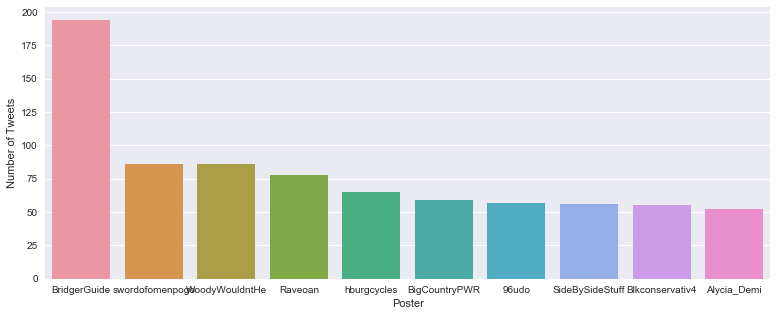

In [92]:
f, ax = plt.subplots(figsize=(13, 5))
p1 = sns.barplot(x="Poster", y = "Count", data = active_users_top10)
p1.set(xlabel='Poster', ylabel='Number of Tweets')
plt.show()

As it can be seen above, most of the tweets are not from customers of Polaris, but from twitter handles of other companies reporting the news/commercial handle which sells the Polaris products. 

__Plotting the most active hours during the day people are tweeting about Polaris__

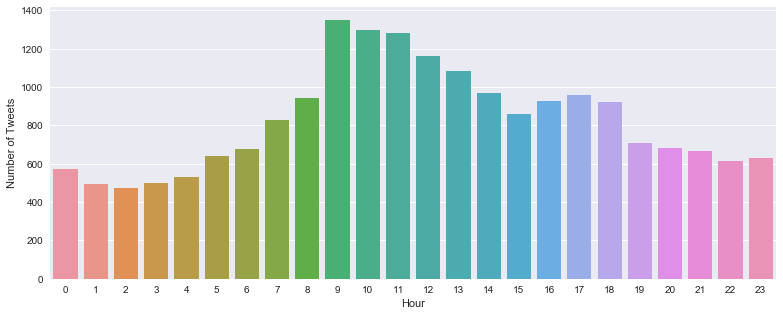

In [93]:
tweets_cleaned['hour']=tweets_cleaned['date'].dt.hour
f, ax = plt.subplots(figsize=(13, 5))
p2 = sns.countplot(x="hour", data = tweets_cleaned)
p2.set(xlabel='Hour', ylabel='Number of Tweets')
plt.show()

As it can be seen from the above plot, people are tweeting the most about Polaris during the business hours of the day. 

__Plotting the number of tweets by month__

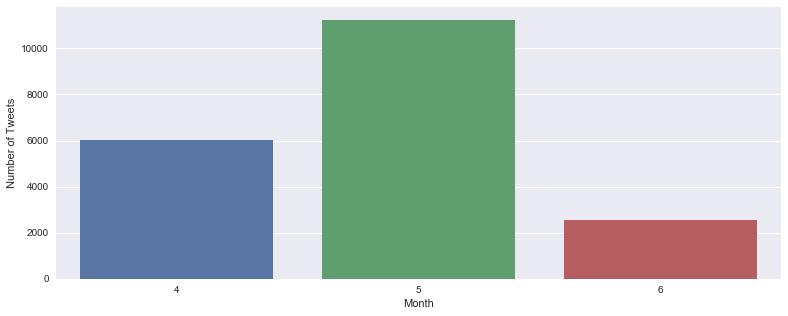

In [94]:
tweets_cleaned['month']=tweets_cleaned['date'].dt.month
f, ax = plt.subplots(figsize=(13, 5))
p3 = sns.countplot(x="month", data = tweets_cleaned)
p3.set(xlabel='Month', ylabel='Number of Tweets')
plt.show()

Unusually, month of May has highest number of tweets. One probable reason might me because of the announcement that Polaris is doing vehicle recalls for the fifth time in 2 years

__WORD CLOUD__

The wordcloud shows the different words present in the tweets of the customers. The size of the word in the world cloud indicates the frequency of the words in the different tweets, with bigger size indicating a high frequency of the words.

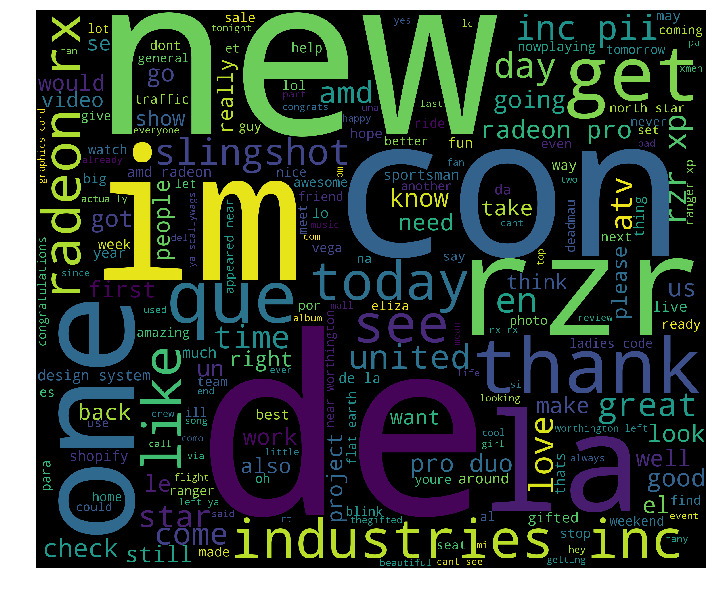

In [105]:
text = (' '.join(list(tweets_cleaned.text)))
cleaned_word = " ".join([word for word in text.split()
                            if 'http' not in word
                                and 'polaris' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=stop,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

As it can be seen from the above image, we can infer that people are talking mostly about new RZR and Slingshoot models.

## Sentiment Analysis of the tweets

__Sentiment Analysis of all the tweets__

For the sentiment analysis of the tweets, I have used the __textblob__ library in Python, which gives out a score between -1 and +1, +1 indicating positive sentiment and -1 indicating negative sentiment. 

In [96]:
def sentiment_analysis_by_text(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    if sentiment_polarity < 0:
        return 'NEGATIVE'
    elif sentiment_polarity <= 0.2:
        return 'NEUTRAL'
    else:
        return 'POSITIVE'

In [97]:
tweets_cleaned['polarity'] = tweets_cleaned.text.apply(sentiment_analysis_by_text)

In [98]:
tweets_cleaned.head()

,username,date,text,hour,month,polarity
0,WaltsOutdoor,2017-06-17 12:23:00,rzr xp w ride command,12,6,NEUTRAL
2,Loisa_Lane,2017-06-17 10:29:00,anjaelina und jetzt noch die con wie coooool ...,10,6,NEUTRAL
6,AwesomeElectro,2017-06-17 00:59:00,hot cams camshaft stage ranger x ranger x efi,0,6,POSITIVE
7,law_michigan,2017-06-17 00:50:00,maier onepiece roof stealth black ranger rzr,0,6,NEGATIVE
8,insurance_boat,2017-06-17 00:14:00,vertex piston kit standard mm ranger rzr xp,0,6,NEUTRAL


__Finding the people who are tweeting most positive about Polaris to understand what these people like the most about the company.__

In [99]:
tweets_positive = tweets_cleaned[tweets_cleaned.polarity=='POSITIVE']
active_users_positive = pd.DataFrame(tweets_positive.groupby(['username']).size().sort_values(ascending = False))
active_users_positive_top10 = active_users_positive.head(10)
active_users_positive_top10 = pd.DataFrame(active_users_positive_top10)
active_users_positive_top10.columns = ['Count']
active_users_positive_top10['Poster'] = active_users_positive_top10.index
active_users_positive_top10

,Count,Poster
username,,
Xtreme_MCG,33,Xtreme_MCG
BridgerGuide,31,BridgerGuide
SideBySideStuff,29,SideBySideStuff
Raveoan,21,Raveoan
WoodyWouldntHe,17,WoodyWouldntHe
Alycia_Demi,16,Alycia_Demi
DHYNJ,14,DHYNJ
united,14,united
jennevergrowsup,14,jennevergrowsup


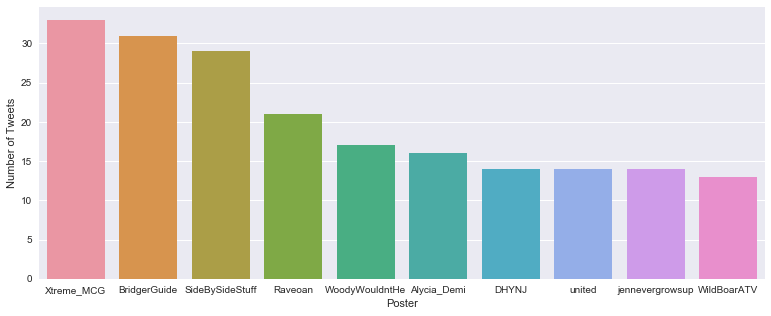

In [100]:
f, ax = plt.subplots(figsize=(13, 5))
p4 = sns.barplot(x="Poster", y = "Count", data = active_users_positive_top10)
p4.set(xlabel='Poster', ylabel='Number of Tweets')
plt.show()

In [101]:
tweets_negative = tweets_cleaned[tweets_cleaned.polarity=='NEGATIVE']
tweets_negative.head()

,username,date,text,hour,month,polarity
7,law_michigan,2017-06-17 00:50:00,maier onepiece roof stealth black ranger rzr,0,6,NEGATIVE
45,LloydsList,2017-06-08 04:41:00,on secondhand buying spree,4,6,NEGATIVE
49,Alycia_Demi,2017-06-08 04:34:00,me after im so broken cant even buy food but ...,4,6,NEGATIVE
61,LyraFay,2017-06-08 04:05:00,simargl is a slavic diety who is tied to the s...,4,6,NEGATIVE
67,buy_an_ipod,2017-06-08 03:40:00,set of studboy deuce bar rush pro s limited...,3,6,NEGATIVE


In [102]:
len(tweets_negative.index)

1676

__Wordcloud of the tweets with negative sentiment__

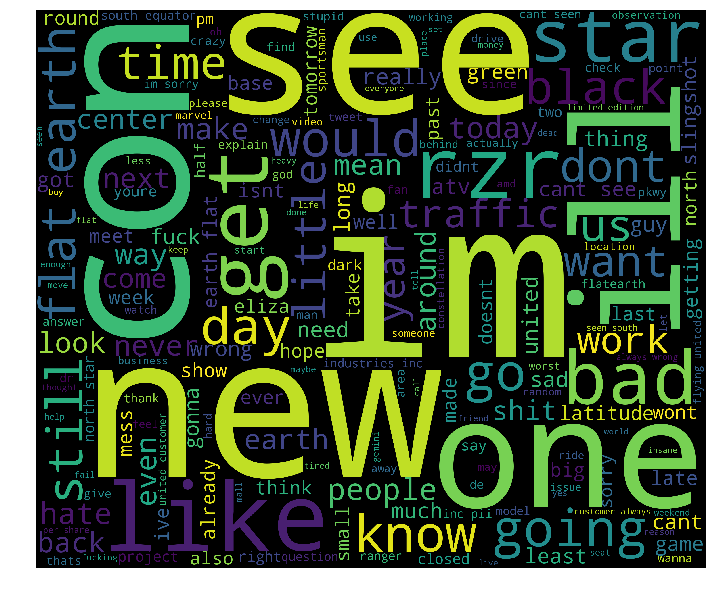

In [114]:
text = (' '.join(list(tweets_negative.text)))
cleaned_word = " ".join([word for word in text.split()
                            if 'http' not in word
                                and 'polaris' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=stop,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

RZR model feature in the negativev tweets mostly. THe word 'new' in the negative tweets means that people are not happy about new RZR models. Thr model family ATV also featured

__Plotting the the polarity of tweets in different months__

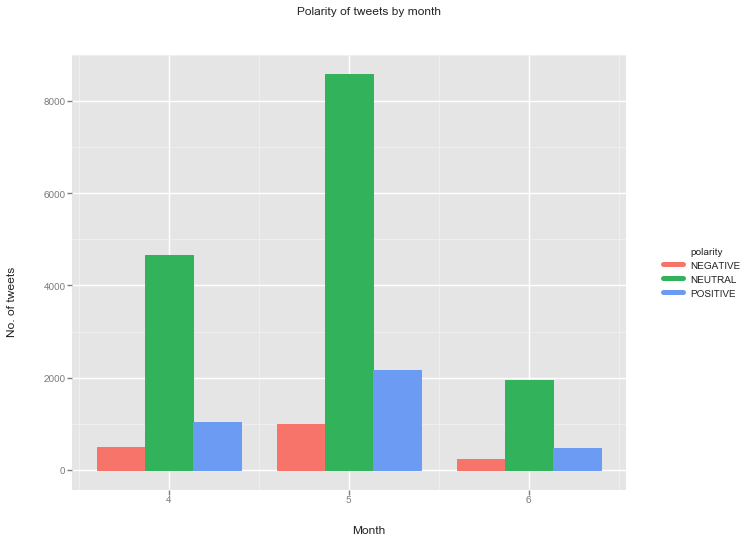

<ggplot: (-9223371870321927550)>

In [46]:
ggplot(tweets_cleaned, aes(x='month',fill="polarity")) + geom_bar() +ggtitle('Polarity of tweets by month') + \
xlab('Month') + ylab('No. of tweets')

The above graph shows skewed results because May had most number of tweets. But, we can notice that the number of negative tweets is almost half the number of positive tweets, which is really a matter of concern

__Plotting the percentage of negative tweets per hour__

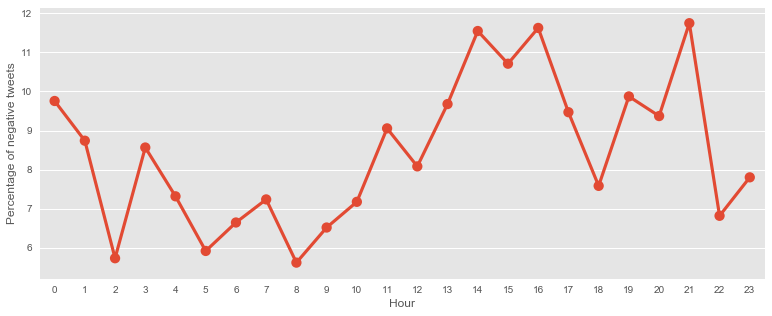

In [107]:
negative_hour=tweets_cleaned[tweets_cleaned['polarity']=='NEGATIVE'].groupby(by=['hour'])['text'].count()
total_hour=tweets_cleaned.groupby(by=['hour'],axis=0)['text'].count()
perc_negativity_hour=pd.DataFrame({'hour':total_hour.index,'negativity':negative_hour*100/total_hour})

f, ax = plt.subplots(figsize=(13, 5))
p5 = sns.pointplot(x="hour", y = "negativity", data = perc_negativity_hour)
p5.set(xlabel='Hour', ylabel='Percentage of negative tweets')
plt.show()

From the above graph, we can see that there is a high precentage of negative tweets from 1 to 5PM and at 8-9PM. There is a lower percentage of negative tweetd during the peak morning hours between 9-12. 


## N-grams on the negative tweets

In [48]:
stop = set(stopwords.words('english'))
def ngrams(tweet,n):
  tokens = nltk.word_tokenize(tweet)
  words = [item for item in tokens if item not in stop]
  output = {}
  for i in range(len(words)-n+1):
    g = ' '.join(words[i:i+n])
    output.setdefault(g, 0)
    output[g] += 1
  return output

In [49]:
doc = tweets_negative['text'].str.cat(sep=' ')
bigrams = ngrams(doc,2)
bigram_df= pd.DataFrame({'keys':list(bigrams.keys()),'values':list(bigrams.values())})
bigram_df.sort_values(by=['values'], ascending=False,inplace=True)
bigram_df.head(10)

,keys,values
962,flat earth,43
122,gon na,22
653,cant see,22
3011,earth flat,19
3008,south equator,17
969,north star,17
4124,inc pii,16
4123,industries inc,16
44,im sorry,15
277,wan na,15


The table above shows the most common pairs of words found in the negative tweets. 

## Word2Vec 

Word2Vec provides us with the words that would be semantically similar to a particuar word. The occurrence of these words in tweets would mean that it might be important to check for these tweets to undersand if the customers are facing any issues. 

In [50]:
tweets_sentences = pd.DataFrame(tweets_negative.text)
tweets_sentences['tokenized_sents'] = tweets_sentences.apply(lambda x: nltk.word_tokenize(x['text']), axis=1)
tweets_sentences['tokenized_sents'] = tweets_sentences['tokenized_sents'].apply(lambda x: [item for item in x if item not in stop])
tweets_sentences.head(3)

,text,tokenized_sents
7,maier onepiece roof stealth black ranger rzr,"[maier, onepiece, roof, stealth, black, ranger..."
33,there is no heads or tails on a rzr it is all ...,"[heads, tails, rzr, abt, extreme, adventure]"
45,on secondhand buying spree,"[secondhand, buying, spree]"


In [51]:
mr = Word2Vec(tweets_sentences.tokenized_sents, min_count=1)

In [113]:
mr.most_similar('service', topn=5)

[('paintballmowers', 0.3287247121334076),
 ('braille', 0.3277398347854614),
 ('ramps', 0.3114885091781616),
 ('known', 0.3101360499858856),
 ('wejp', 0.30282577872276306)]

The top 5 most semantically similar words to 'service' are shown above. This is polluted with spanish tweets.

## Topic Modelling

__Topic Modelling using the LDA algorithm to find the most probable topics people with negative sentiment are tweeting about.__

In [53]:
tweets_sentences.head()

,text,tokenized_sents
7,maier onepiece roof stealth black ranger rzr,"[maier, onepiece, roof, stealth, black, ranger..."
33,there is no heads or tails on a rzr it is all ...,"[heads, tails, rzr, abt, extreme, adventure]"
45,on secondhand buying spree,"[secondhand, buying, spree]"
49,me after im so broken cant even buy food but ...,"[im, broken, cant, even, buy, food, worth]"
61,simargl is a slavic diety who is tied to the s...,"[simargl, slavic, diety, tied, star, watched, ..."


In [54]:
documents = tweets_sentences.tokenized_sents
dictionary = corpora.Dictionary(documents)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in documents]

In [55]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=7,id2word= dictionary,alpha='auto', passes=60, chunksize=100)

In [56]:
(ldamodel.print_topics())

[(0,
  '0.034*"see" + 0.030*"cant" + 0.027*"little" + 0.025*"earth" + 0.022*"flat" + 0.019*"star" + 0.012*"north" + 0.011*"due" + 0.010*"australia" + 0.008*"want"'),
 (1,
  '0.017*"flatearth" + 0.016*"sorry" + 0.013*"south" + 0.013*"pii" + 0.012*"explain" + 0.012*"industries" + 0.008*"seen" + 0.008*"services" + 0.008*"consulting" + 0.008*"wide"'),
 (2,
  '0.019*"shit" + 0.016*"rzr" + 0.015*"go" + 0.015*"one" + 0.012*"answer" + 0.010*"launches" + 0.009*"week" + 0.009*"la" + 0.009*"way" + 0.009*"…"'),
 (3,
  '0.025*"united" + 0.015*"slingshot" + 0.012*"center" + 0.011*"check" + 0.011*"day" + 0.010*"ask" + 0.009*"let" + 0.009*"long" + 0.008*"lounge" + 0.008*"powered"'),
 (4,
  '0.032*"rx" + 0.016*"game" + 0.015*"back" + 0.015*"gaming" + 0.011*"vega" + 0.011*"green" + 0.010*"ゲーム" + 0.010*"still" + 0.010*"new" + 0.009*"less"'),
 (5,
  '0.030*"im" + 0.022*"ill" + 0.018*"con" + 0.015*"like" + 0.015*"hate" + 0.014*"bad" + 0.011*"mean" + 0.011*"time" + 0.010*"dont" + 0.009*"going"'),
 (6,
  '0.

The results above show the 7 different topics that were created, and the top 7 words that are contributing the most to each of the topics in decreasing order. Topic modelling collects the different social media posts and sorts them into the different topics. As it can be seen, the topic 0 talks about adventure

But the interesting topic is second. People talk negatively about RZR and it is once again clear. This helps us find out the different topics that the cutomers are posting about on social media.

## Sumamry

<li><strong>To summarise, RZR, Slingshot, Sportsman models are most talked about in the Social Media. This includes reselling advertisements as well</strong></li>
<li><strong>But people are not happy with RZR models. But Slingshot and Razor are appearing less in negative tweets means people are relatively ok with those models</strong></li>

## Road ahead

<li><strong>Could no infer anything related to Polaris' service, warranty conditions or vehicle experience from the tweets. This is because there are too many tweets on reselling advertisment, which mislead the text analysis. Hence, the next step would be to filter out the advertisement tweets and other tweets from the stock recommendation companies</strong></li>
<li><strong>One more step would be to filter out the non English language words which clutter the word cloud</strong></li>